# Visualize States

In [1]:
import os
import glob
import pickle
import re
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import groupby


Model with k = 10 states
AIC = 444442.5, BIC = 454688.3


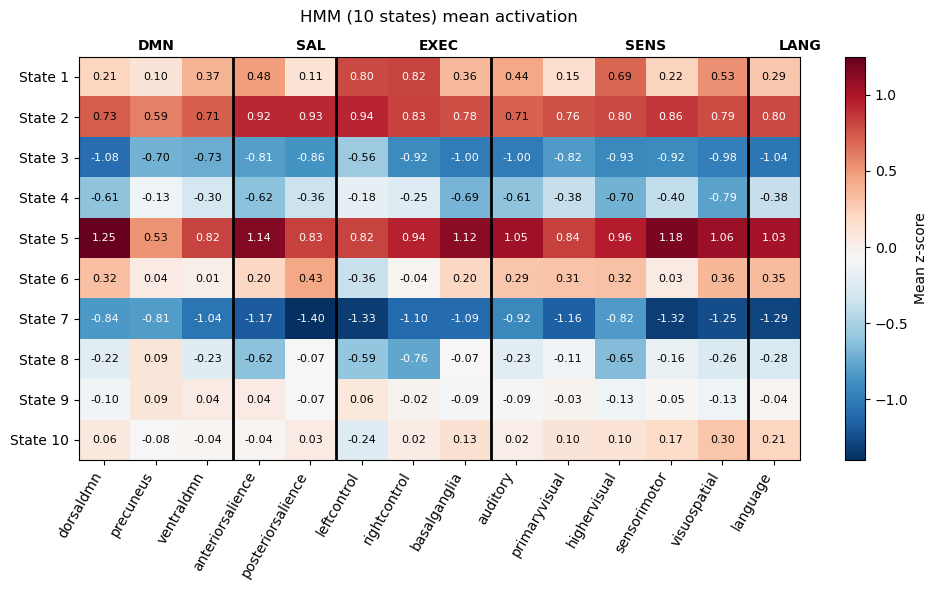

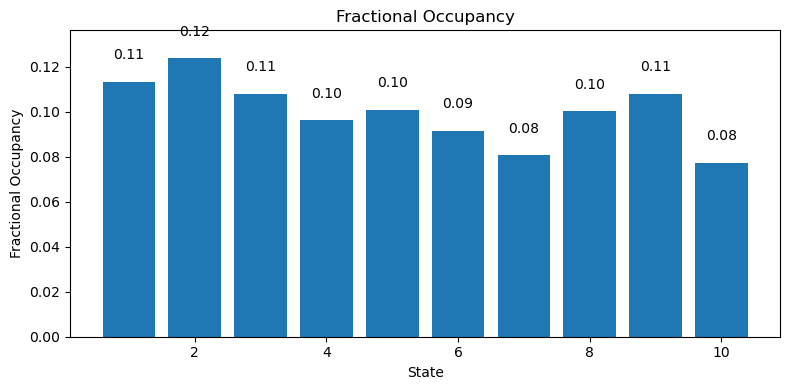

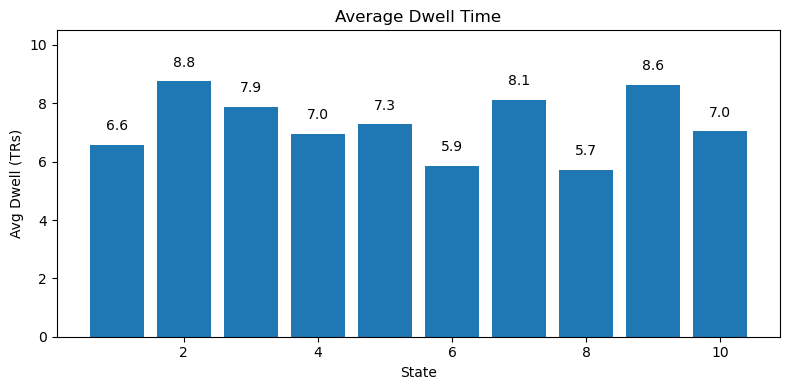


Top‑3 networks per state:
 State 1: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 2: ['leftcontrol', 'posteriorsalience', 'anteriorsalience']
 State 3: ['leftcontrol', 'precuneus', 'ventraldmn']
 State 4: ['precuneus', 'leftcontrol', 'rightcontrol']
 State 5: ['dorsaldmn', 'sensorimotor', 'anteriorsalience']
 State 6: ['posteriorsalience', 'visuospatial', 'language']
 State 7: ['precuneus', 'highervisual', 'dorsaldmn']
 State 8: ['precuneus', 'posteriorsalience', 'basalganglia']
 State 9: ['precuneus', 'leftcontrol', 'anteriorsalience']
 State 10: ['visuospatial', 'language', 'sensorimotor']

Fractional occupancy per state:
 State 1: 0.113
 State 2: 0.124
 State 3: 0.108
 State 4: 0.096
 State 5: 0.101
 State 6: 0.092
 State 7: 0.081
 State 8: 0.100
 State 9: 0.108
 State 10: 0.077

State transition matrix:
[[0.833 0.047 0.009 0.009 0.027 0.023 0.002 0.013 0.018 0.017]
 [0.031 0.874 0.    0.    0.049 0.022 0.    0.001 0.023 0.   ]
 [0.022 0.    0.849 0.033 0.    0.008 0.02  0

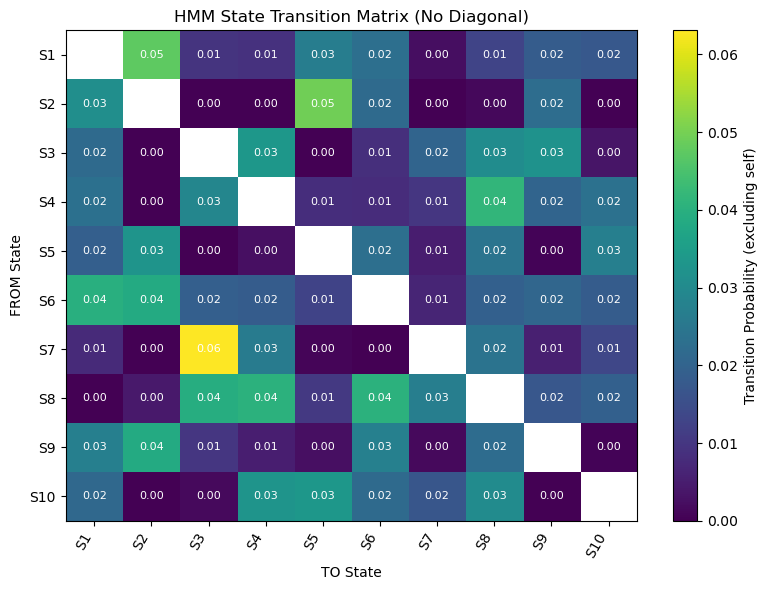


Model with k = 12 states
AIC = 445107.2, BIC = 457594.7


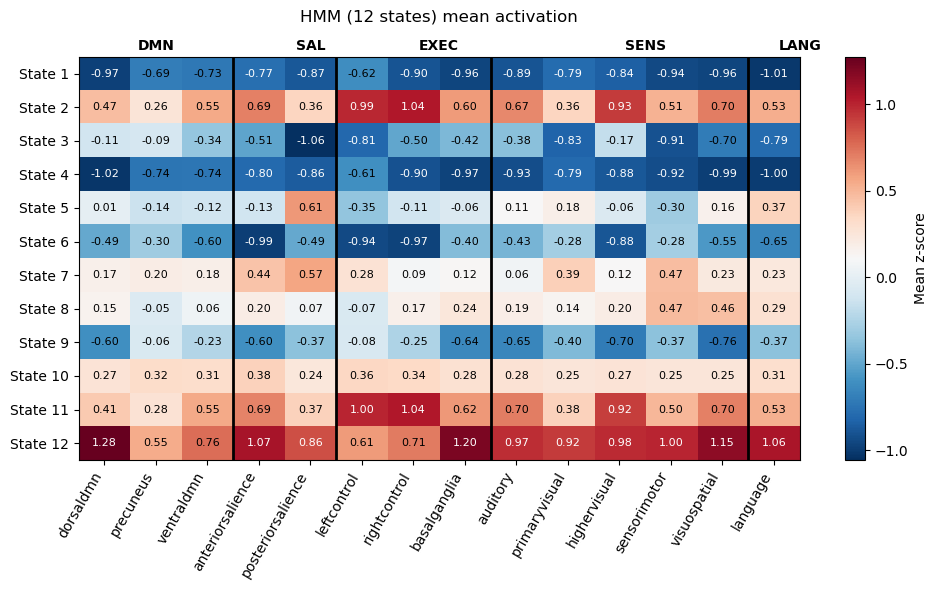

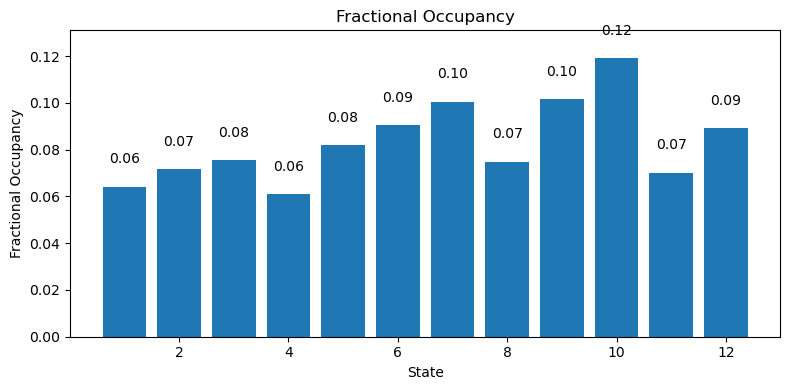

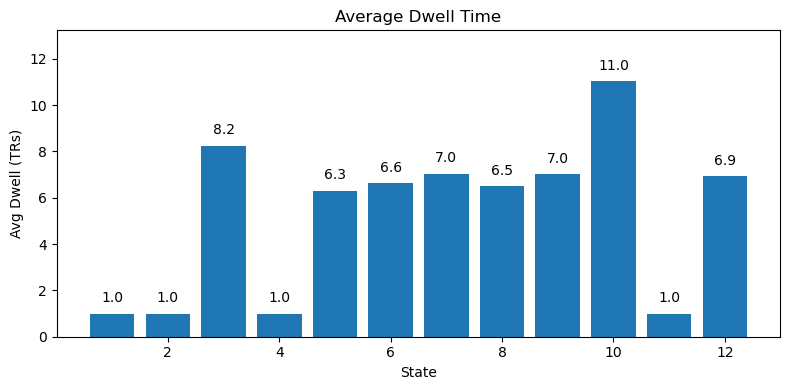


Top‑3 networks per state:
 State 1: ['leftcontrol', 'precuneus', 'ventraldmn']
 State 2: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 3: ['precuneus', 'dorsaldmn', 'highervisual']
 State 4: ['leftcontrol', 'ventraldmn', 'precuneus']
 State 5: ['posteriorsalience', 'language', 'primaryvisual']
 State 6: ['sensorimotor', 'primaryvisual', 'precuneus']
 State 7: ['posteriorsalience', 'sensorimotor', 'anteriorsalience']
 State 8: ['sensorimotor', 'visuospatial', 'language']
 State 9: ['precuneus', 'leftcontrol', 'ventraldmn']
 State 10: ['anteriorsalience', 'leftcontrol', 'rightcontrol']
 State 11: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 12: ['dorsaldmn', 'basalganglia', 'visuospatial']

Fractional occupancy per state:
 State 1: 0.064
 State 2: 0.072
 State 3: 0.076
 State 4: 0.061
 State 5: 0.082
 State 6: 0.090
 State 7: 0.101
 State 8: 0.075
 State 9: 0.102
 State 10: 0.119
 State 11: 0.070
 State 12: 0.089

State transition matrix:
[[0.    0.    0.03  0.899 0. 

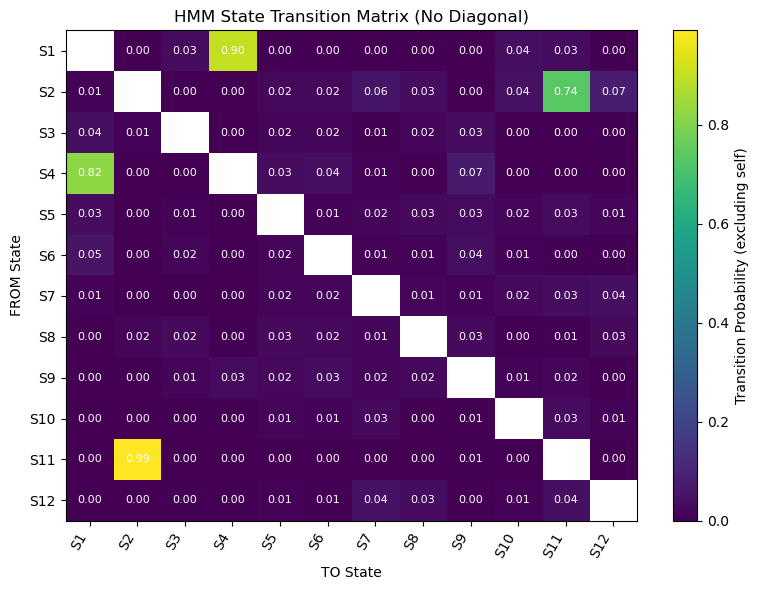


Model with k = 14 states
AIC = 436946.4, BIC = 451738.9


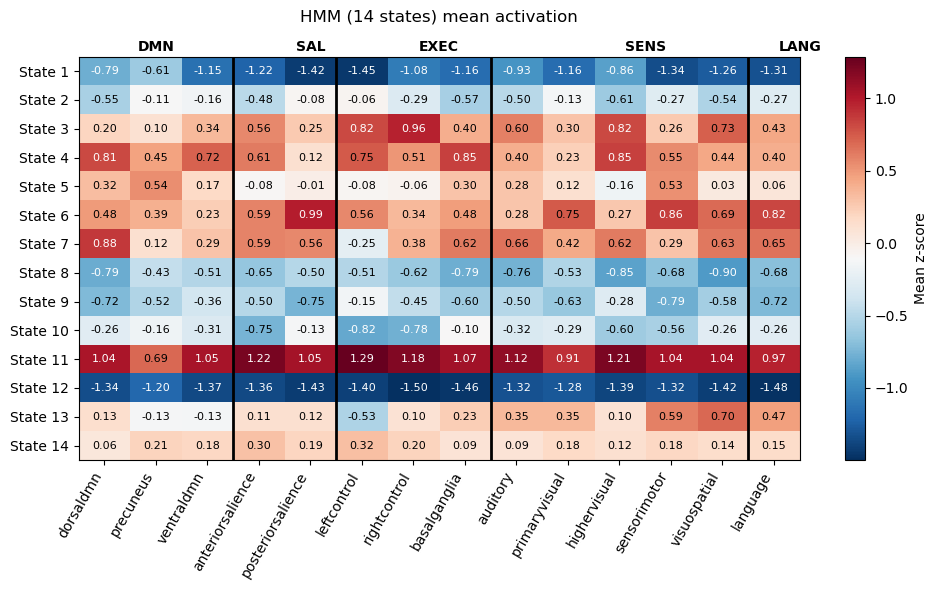

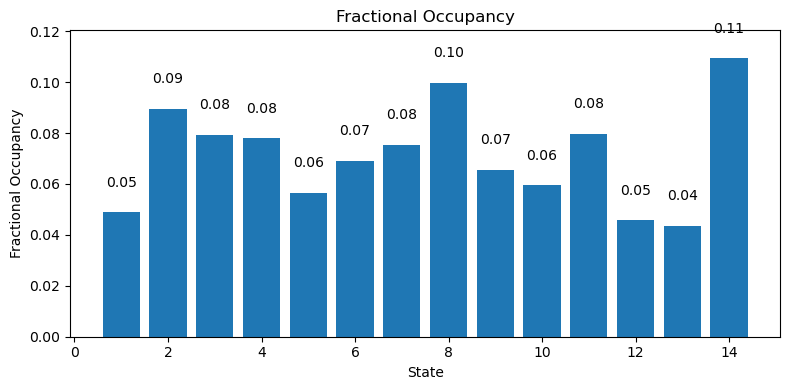

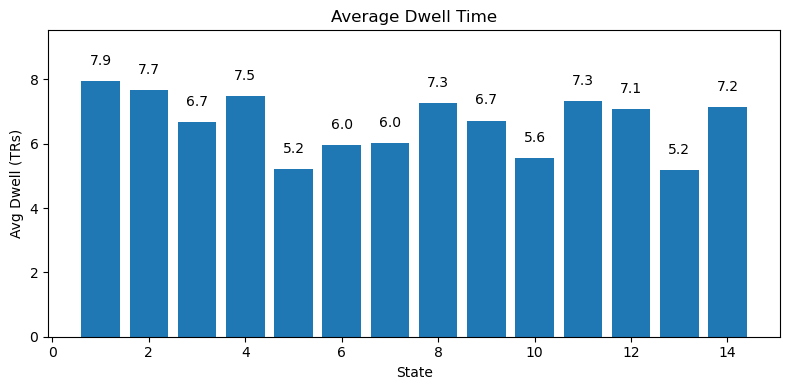


Top‑3 networks per state:
 State 1: ['precuneus', 'dorsaldmn', 'highervisual']
 State 2: ['leftcontrol', 'posteriorsalience', 'precuneus']
 State 3: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 4: ['basalganglia', 'highervisual', 'dorsaldmn']
 State 5: ['precuneus', 'sensorimotor', 'dorsaldmn']
 State 6: ['posteriorsalience', 'sensorimotor', 'language']
 State 7: ['dorsaldmn', 'auditory', 'language']
 State 8: ['precuneus', 'posteriorsalience', 'ventraldmn']
 State 9: ['leftcontrol', 'highervisual', 'ventraldmn']
 State 10: ['basalganglia', 'posteriorsalience', 'precuneus']
 State 11: ['leftcontrol', 'anteriorsalience', 'highervisual']
 State 12: ['precuneus', 'primaryvisual', 'auditory']
 State 13: ['visuospatial', 'sensorimotor', 'language']
 State 14: ['leftcontrol', 'anteriorsalience', 'precuneus']

Fractional occupancy per state:
 State 1: 0.049
 State 2: 0.089
 State 3: 0.079
 State 4: 0.078
 State 5: 0.056
 State 6: 0.069
 State 7: 0.075
 State 8: 0.100
 State 9: 0.06

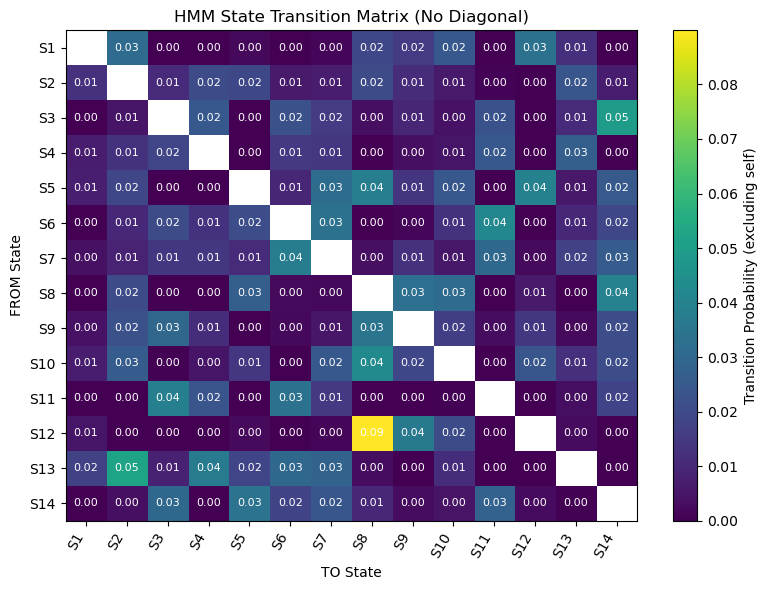


Model with k = 16 states
AIC = 437487.8, BIC = 454649.0


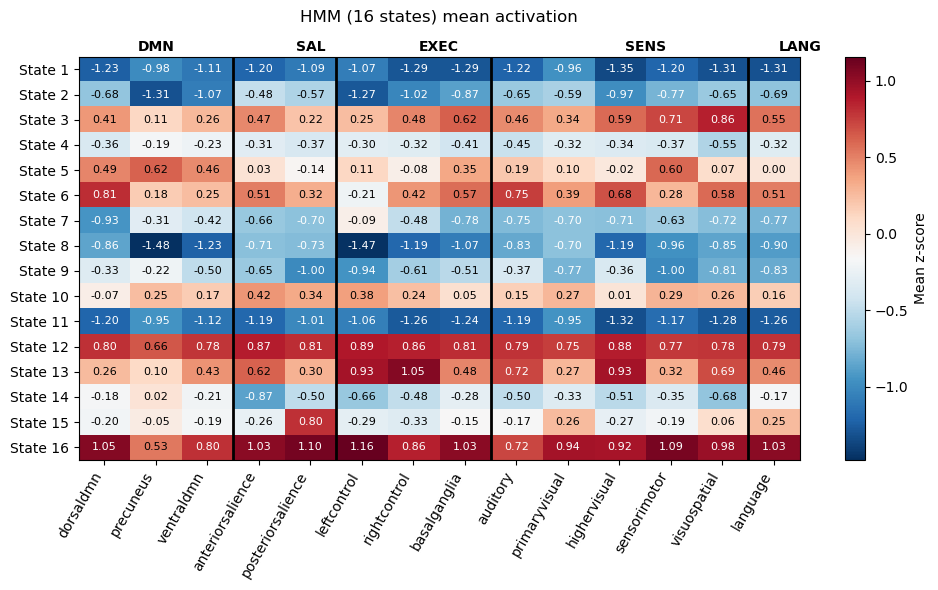

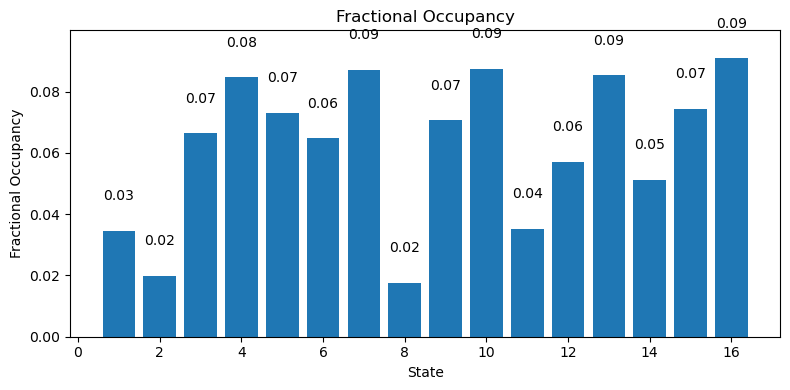

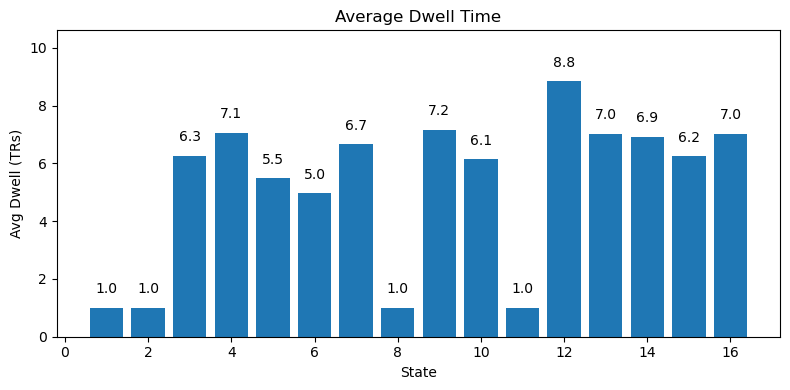


Top‑3 networks per state:
 State 1: ['primaryvisual', 'precuneus', 'leftcontrol']
 State 2: ['anteriorsalience', 'posteriorsalience', 'primaryvisual']
 State 3: ['visuospatial', 'sensorimotor', 'basalganglia']
 State 4: ['precuneus', 'ventraldmn', 'leftcontrol']
 State 5: ['precuneus', 'sensorimotor', 'dorsaldmn']
 State 6: ['dorsaldmn', 'auditory', 'highervisual']
 State 7: ['leftcontrol', 'precuneus', 'ventraldmn']
 State 8: ['primaryvisual', 'anteriorsalience', 'posteriorsalience']
 State 9: ['precuneus', 'dorsaldmn', 'highervisual']
 State 10: ['anteriorsalience', 'leftcontrol', 'posteriorsalience']
 State 11: ['primaryvisual', 'precuneus', 'posteriorsalience']
 State 12: ['leftcontrol', 'highervisual', 'anteriorsalience']
 State 13: ['rightcontrol', 'highervisual', 'leftcontrol']
 State 14: ['precuneus', 'language', 'dorsaldmn']
 State 15: ['posteriorsalience', 'primaryvisual', 'language']
 State 16: ['leftcontrol', 'posteriorsalience', 'sensorimotor']

Fractional occupancy per s

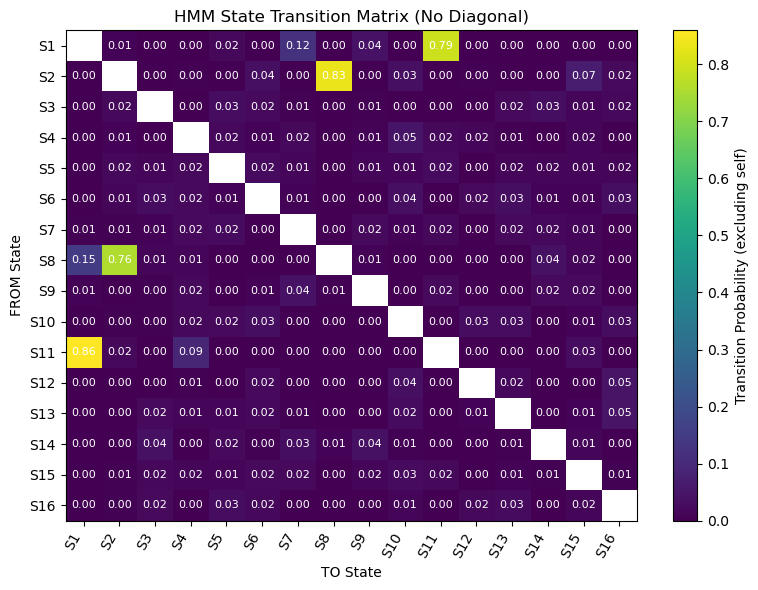


Model with k = 20 states
AIC = 434339.9, BIC = 456429.3


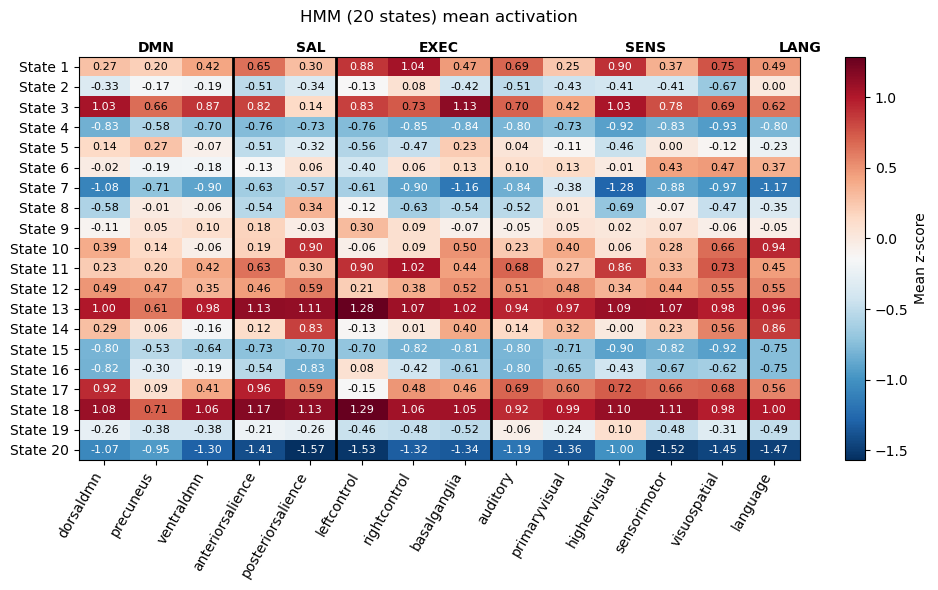

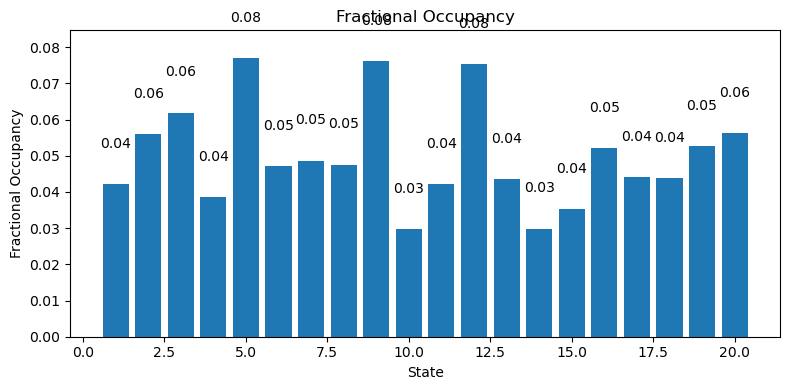

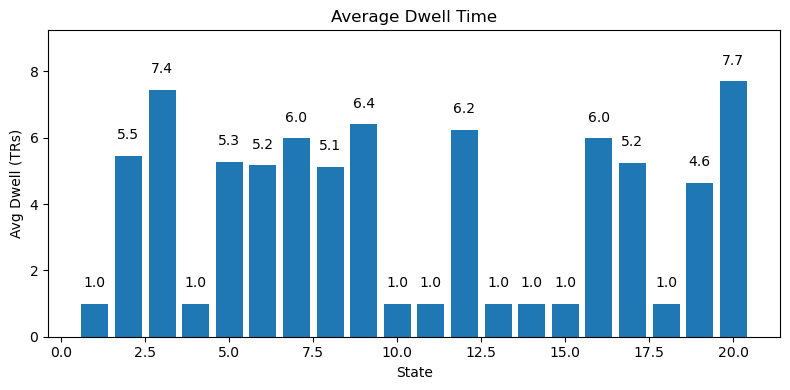


Top‑3 networks per state:
 State 1: ['rightcontrol', 'highervisual', 'leftcontrol']
 State 2: ['rightcontrol', 'language', 'leftcontrol']
 State 3: ['basalganglia', 'dorsaldmn', 'highervisual']
 State 4: ['precuneus', 'ventraldmn', 'posteriorsalience']
 State 5: ['precuneus', 'basalganglia', 'dorsaldmn']
 State 6: ['visuospatial', 'sensorimotor', 'language']
 State 7: ['primaryvisual', 'posteriorsalience', 'leftcontrol']
 State 8: ['posteriorsalience', 'primaryvisual', 'precuneus']
 State 9: ['leftcontrol', 'anteriorsalience', 'ventraldmn']
 State 10: ['language', 'posteriorsalience', 'visuospatial']
 State 11: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 12: ['posteriorsalience', 'visuospatial', 'language']
 State 13: ['leftcontrol', 'anteriorsalience', 'posteriorsalience']
 State 14: ['language', 'posteriorsalience', 'visuospatial']
 State 15: ['precuneus', 'ventraldmn', 'posteriorsalience']
 State 16: ['leftcontrol', 'ventraldmn', 'precuneus']
 State 17: ['anteriorsalienc

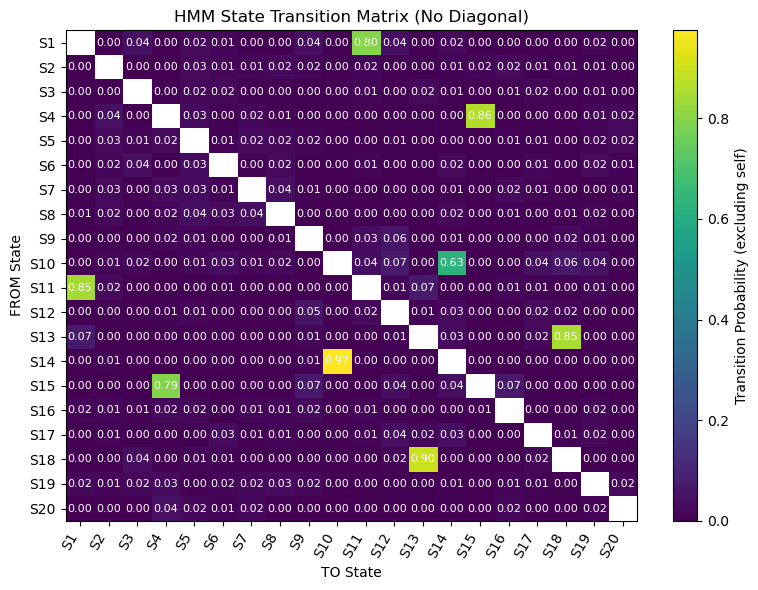


Model with k = 4 states
AIC = 466557.2, BIC = 470460.0


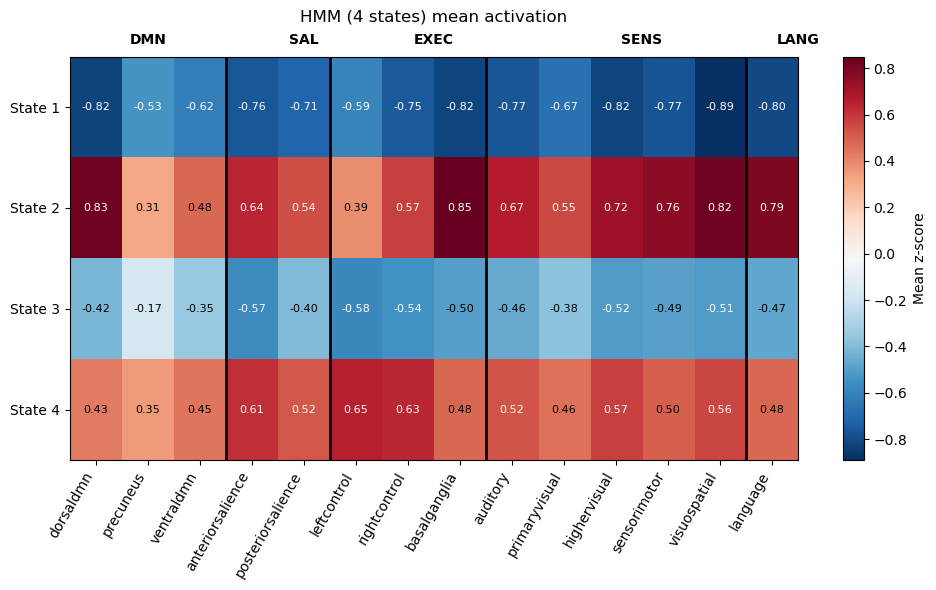

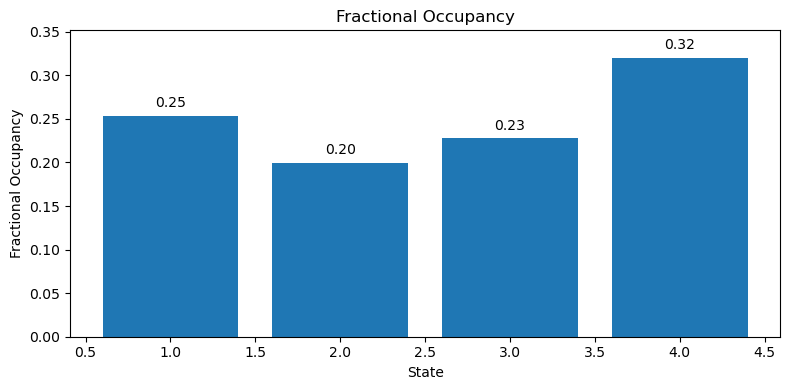

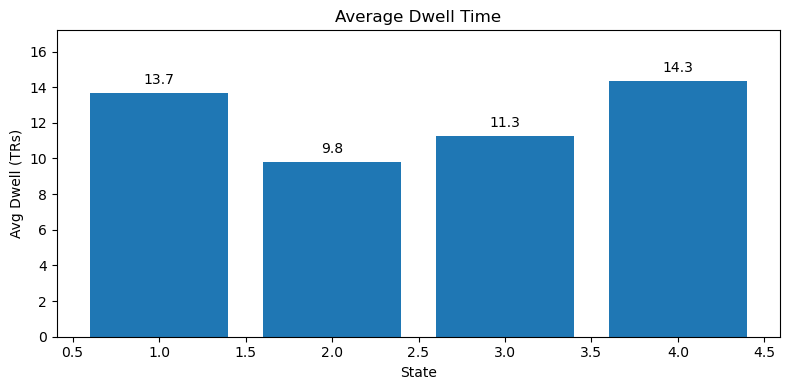


Top‑3 networks per state:
 State 1: ['precuneus', 'leftcontrol', 'ventraldmn']
 State 2: ['basalganglia', 'dorsaldmn', 'visuospatial']
 State 3: ['precuneus', 'ventraldmn', 'primaryvisual']
 State 4: ['leftcontrol', 'rightcontrol', 'anteriorsalience']

Fractional occupancy per state:
 State 1: 0.253
 State 2: 0.199
 State 3: 0.228
 State 4: 0.320

State transition matrix:
[[0.908 0.005 0.05  0.037]
 [0.003 0.886 0.041 0.07 ]
 [0.07  0.029 0.887 0.013]
 [0.019 0.052 0.008 0.921]]


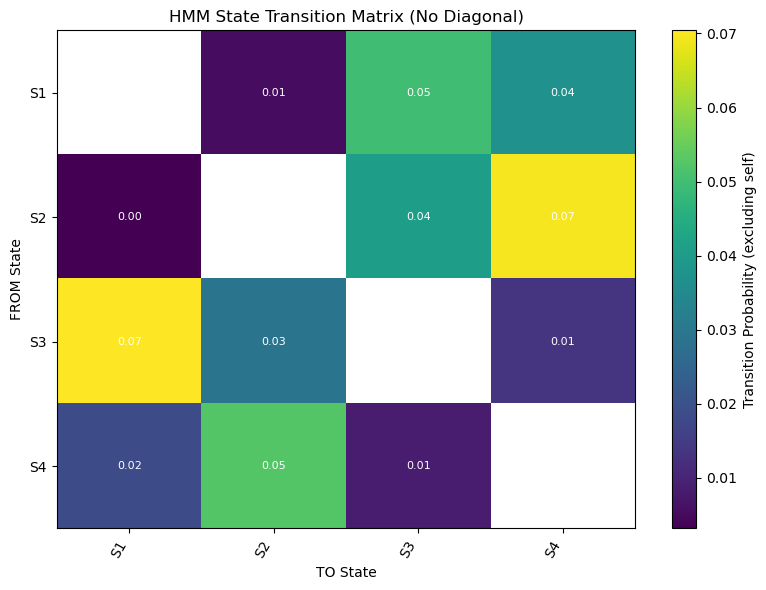


Model with k = 6 states
AIC = 456304.7, BIC = 462258.3


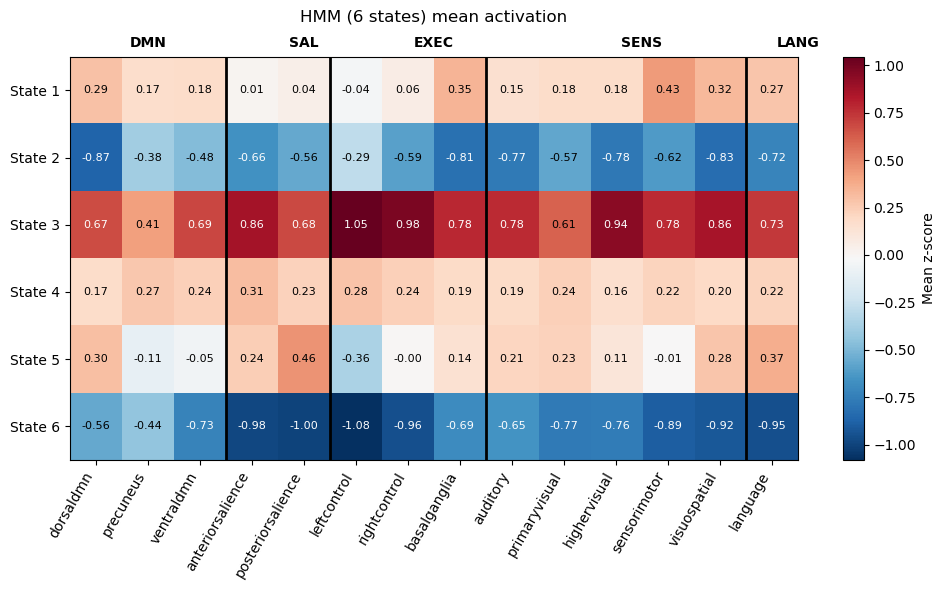

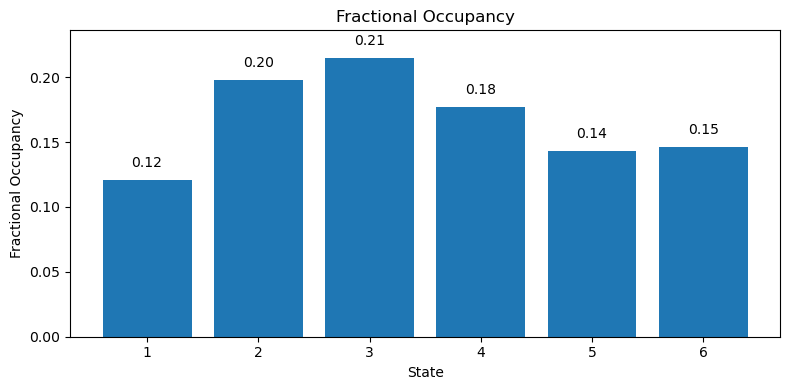

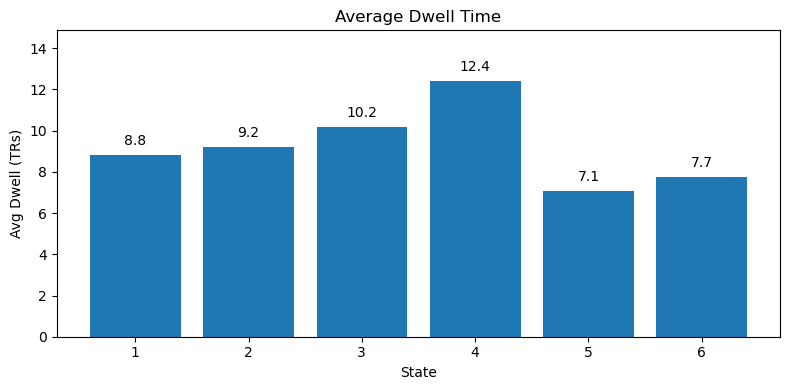


Top‑3 networks per state:
 State 1: ['sensorimotor', 'basalganglia', 'visuospatial']
 State 2: ['leftcontrol', 'precuneus', 'ventraldmn']
 State 3: ['leftcontrol', 'rightcontrol', 'highervisual']
 State 4: ['anteriorsalience', 'leftcontrol', 'precuneus']
 State 5: ['posteriorsalience', 'language', 'dorsaldmn']
 State 6: ['precuneus', 'dorsaldmn', 'auditory']

Fractional occupancy per state:
 State 1: 0.121
 State 2: 0.198
 State 3: 0.215
 State 4: 0.177
 State 5: 0.143
 State 6: 0.146

State transition matrix:
[[0.87  0.024 0.037 0.    0.035 0.035]
 [0.018 0.874 0.019 0.023 0.022 0.045]
 [0.029 0.005 0.897 0.03  0.028 0.011]
 [0.    0.009 0.05  0.899 0.032 0.01 ]
 [0.025 0.045 0.048 0.031 0.839 0.012]
 [0.019 0.086 0.002 0.016 0.022 0.855]]


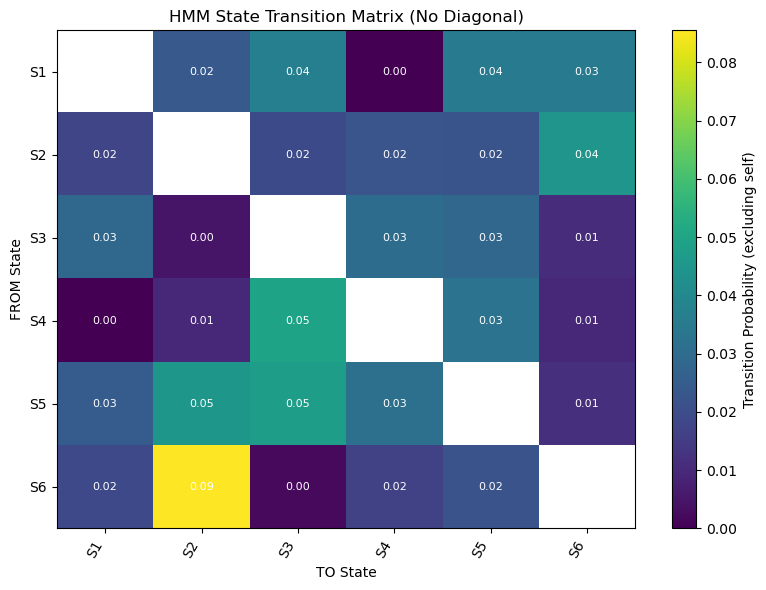


Model with k = 8 states
AIC = 449970.8, BIC = 458038.8


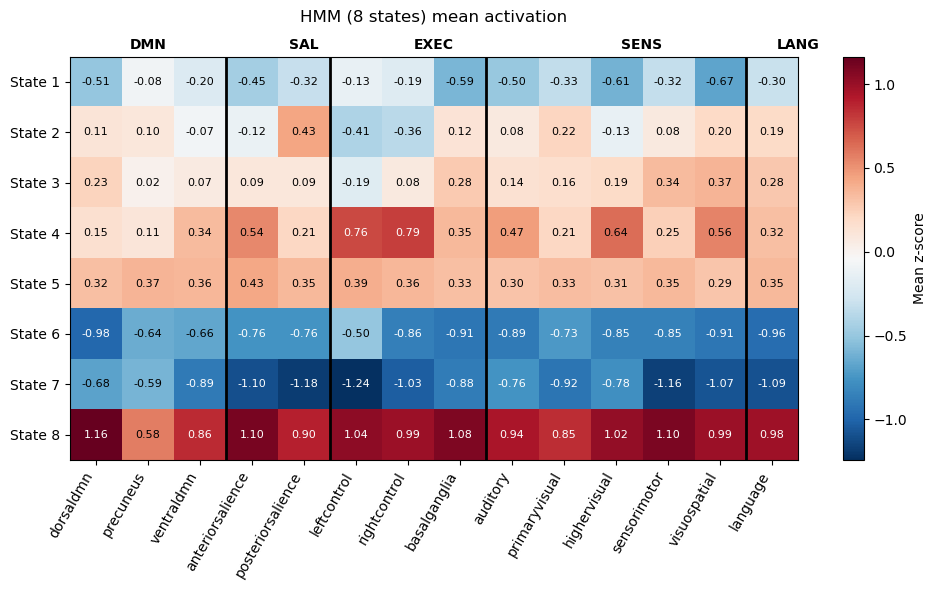

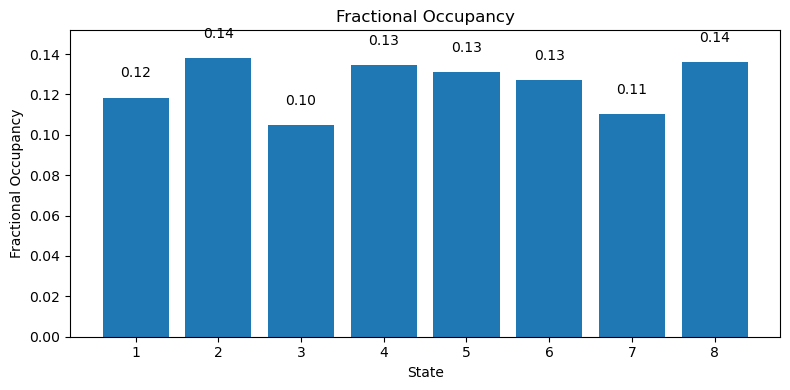

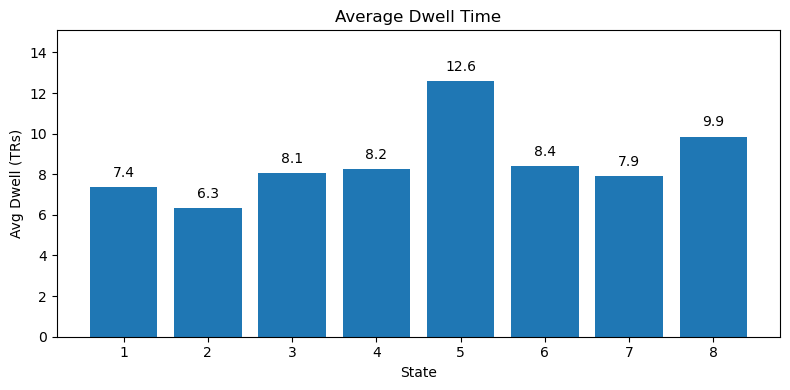


Top‑3 networks per state:
 State 1: ['precuneus', 'leftcontrol', 'rightcontrol']
 State 2: ['posteriorsalience', 'primaryvisual', 'visuospatial']
 State 3: ['visuospatial', 'sensorimotor', 'language']
 State 4: ['rightcontrol', 'leftcontrol', 'highervisual']
 State 5: ['anteriorsalience', 'leftcontrol', 'precuneus']
 State 6: ['leftcontrol', 'precuneus', 'ventraldmn']
 State 7: ['precuneus', 'dorsaldmn', 'auditory']
 State 8: ['dorsaldmn', 'anteriorsalience', 'sensorimotor']

Fractional occupancy per state:
 State 1: 0.118
 State 2: 0.138
 State 3: 0.105
 State 4: 0.134
 State 5: 0.131
 State 6: 0.127
 State 7: 0.110
 State 8: 0.136

State transition matrix:
[[0.841 0.031 0.027 0.026 0.012 0.035 0.02  0.008]
 [0.034 0.817 0.022 0.028 0.028 0.032 0.021 0.017]
 [0.029 0.036 0.86  0.02  0.    0.001 0.024 0.031]
 [0.01  0.032 0.019 0.858 0.027 0.009 0.    0.044]
 [0.005 0.032 0.    0.028 0.903 0.005 0.001 0.025]
 [0.039 0.027 0.004 0.019 0.02  0.858 0.033 0.   ]
 [0.035 0.023 0.014 0.002 

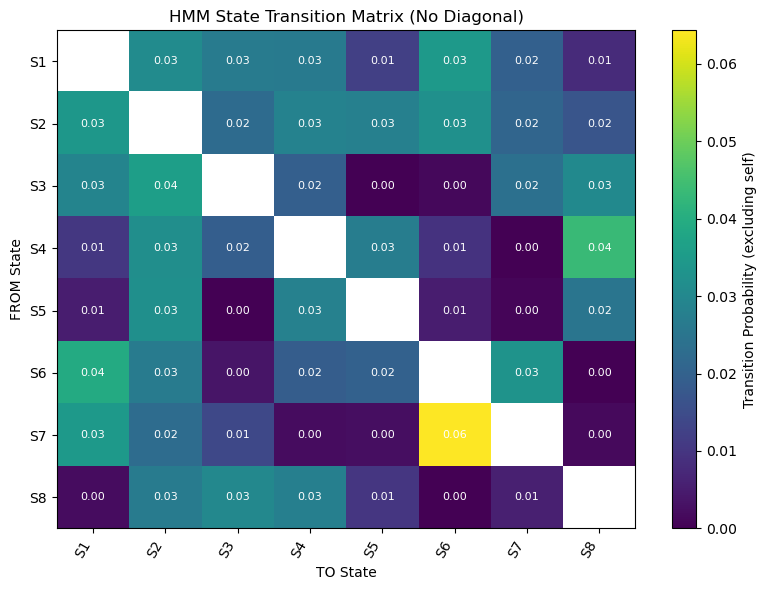

In [3]:
# ─── SETTINGS ─────────────────────────────────────────────────────
INPUT_DIR = "/home/jovyan/narratives-project/shirer_components"
PKL_DIR   = "/home/jovyan/narratives-project/hmm-objects"
DATASET   = "timeseries"
# ──────────────────────────────────────────────────────────────────

def load_and_normalize_h5_files(input_dir, dataset_name=DATASET):
    """Return a list of z‑scored network‑level arrays (timepoints × networks)."""
    files = sorted(glob.glob(os.path.join(input_dir, "*.h5")))
    if not files:
        raise FileNotFoundError(f"No .h5 files in {input_dir}")

    data_list = []
    for fp in files:
        with h5py.File(fp, "r") as f:
            arr = f[dataset_name][()]
        data_list.append(StandardScaler().fit_transform(arr.T))
    return data_list


def get_network_names(input_dir):
    """Pull the network labels from the first Shirer .h5 file."""
    files = sorted(glob.glob(os.path.join(input_dir, "*.h5")))
    if not files:
        raise FileNotFoundError("No .h5 files to read network names")
    with h5py.File(files[0], "r") as f:
        raw = f["network"][()]
    return [b.decode() if isinstance(b, (bytes, bytearray)) else str(b) for b in raw]

# ─── VISUALIZATION HELPERS ───────────────────────────────────────

def plot_transition_heatmap(transmat):
    K = transmat.shape[0]
    mat = transmat.copy(); np.fill_diagonal(mat, np.nan)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(mat, aspect="auto", cmap="viridis")
    plt.colorbar(im, label="Transition Probability (excluding self)")
    plt.xticks(range(K), [f"S{i+1}" for i in range(K)], rotation=60, ha="right")
    plt.yticks(range(K), [f"S{i+1}" for i in range(K)])
    plt.xlabel("TO State"); plt.ylabel("FROM State")
    for i in range(K):
        for j in range(K):
            if i != j:
                plt.text(j, i, f"{transmat[i, j]:.2f}", ha="center", va="center", fontsize=8, color="white")
    plt.title("HMM State Transition Matrix (No Diagonal)"); plt.tight_layout(); plt.show()


def visualize_states(model, concat_data, network_names):
    if not hasattr(model, "means_"):
        raise TypeError("Provided object is not an HMM model (missing 'means_').")

    K, _ = model.means_.shape; means = model.means_

    fam_order = [
        "dorsaldmn", "precuneus", "ventraldmn",
        "anteriorsalience", "posteriorsalience",
        "leftcontrol", "rightcontrol", "basalganglia",
        "auditory", "primaryvisual", "highervisual", "sensorimotor", "visuospatial",
        "language",
    ]
    idx_map = {n: i for i, n in enumerate(network_names)}
    reordered_idx = [idx_map[n] for n in fam_order if n in idx_map]
    labels = [n for n in fam_order if n in idx_map]
    means_reordered = means[:, reordered_idx]

    # heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(means_reordered, aspect="auto", cmap="RdBu_r", vmin=means.min(), vmax=means.max())
    ax.set_yticks(range(K)); ax.set_yticklabels([f"State {i+1}" for i in range(K)])
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=60, ha="right")
    plt.colorbar(im, ax=ax, label="Mean z‑score"); ax.set_title(f"HMM ({K} states) mean activation", pad=25)
    for i in range(K):
        for j, lbl in enumerate(labels):
            val = means_reordered[i, j]
            color = "black" if abs(val) < (means.max() * 0.6) else "white"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=color)
    # family separators & labels
    fam_sizes = [3, 2, 3, 5, 1]; cum = np.cumsum(fam_sizes)
    for b in cum[:-1]:
        ax.axvline(b - 0.5, color="k", lw=2)
    for i, grp in enumerate(["DMN", "SAL", "EXEC", "SENS", "LANG"]):
        mid = (cum[i] + cum[i-1] if i > 0 else (cum[0]-1)) / 2
        ax.text(mid, -0.6, grp, ha="center", va="bottom", fontsize=10, fontweight="bold", transform=ax.transData)
    plt.tight_layout(); plt.show()

    # fractional occupancy & dwell time
    seq = model.predict(concat_data)
    occ = np.bincount(seq, minlength=K) / len(seq)
    plt.figure(figsize=(8, 4)); bars = plt.bar(range(1, K+1), occ)
    plt.xlabel("State"); plt.ylabel("Fractional Occupancy"); plt.ylim(0, occ.max()*1.1)
    for i, b in enumerate(bars): plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f"{occ[i]:.2f}", ha="center")
    plt.title("Fractional Occupancy"); plt.tight_layout(); plt.show()

    dwell = {s: [] for s in range(K)}
    for s, grp in groupby(seq): dwell[s].append(len(list(grp)))
    avg_dwell = [np.mean(dwell[s]) if dwell[s] else 0 for s in range(K)]
    plt.figure(figsize=(8, 4)); bars = plt.bar(range(1, K+1), avg_dwell)
    plt.xlabel("State"); plt.ylabel("Avg Dwell (TRs)"); plt.ylim(0, max(avg_dwell)*1.2)
    for i, b in enumerate(bars): plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f"{avg_dwell[i]:.1f}", ha="center")
    plt.title("Average Dwell Time"); plt.tight_layout(); plt.show()

    print("\nTop‑3 networks per state:")
    for i, m in enumerate(means):
        best = np.argsort(m)[-3:][::-1]
        print(f" State {i+1}: {[network_names[j] for j in best]}")
    print("\nFractional occupancy per state:")
    for i, o in enumerate(occ):
        print(f" State {i+1}: {o:.3f}")
    print("\nState transition matrix:")
    print(np.round(model.transmat_, 3))
    plot_transition_heatmap(model.transmat_)

# ─── MAIN ─────────────────────────────────────────────────────────

def select_best_from_list(obj_list):
    """Pick the entry with the lowest AIC (if present) or highest logL."""
    candidates = [d for d in obj_list if isinstance(d, dict) and "model" in d]
    if not candidates:
        raise ValueError("List does not contain any dicts with a 'model' key")
    if "AIC" in candidates[0]:
        return min(candidates, key=lambda d: d.get("AIC", np.inf))
    return max(candidates, key=lambda d: d.get("logL", -np.inf))


def main():
    data_list = load_and_normalize_h5_files(INPUT_DIR); concat = np.vstack(data_list)
    network_names = get_network_names(INPUT_DIR)

    pkl_files = sorted(glob.glob(os.path.join(PKL_DIR, "*.pkl")))
    if not pkl_files:
        raise FileNotFoundError(f"No .pkl files in {PKL_DIR}")

    for pkl_fp in pkl_files:
        base = os.path.basename(pkl_fp); m = re.search(r"k(\d+)", base); k_hint = int(m.group(1)) if m else None
        with open(pkl_fp, "rb") as f: obj = pickle.load(f)

        # unwrap list‑style result pickles
        if isinstance(obj, list):
            try:
                best = select_best_from_list(obj)
                model, aic, bic, k = best["model"], best.get("AIC"), best.get("BIC"), best.get("k", k_hint)
            except Exception as e:
                print(f"[WARN] Skipping {base}: {e}"); continue
        elif isinstance(obj, dict) and "model" in obj:
            model, aic, bic, k = obj["model"], obj.get("AIC"), obj.get("BIC"), obj.get("k", k_hint)
        else:
            model, aic, bic, k = obj, None, None, k_hint

        if not hasattr(model, "means_"):
            print(f"[WARN] Object in {base} is not an HMM model. Skipping."); continue

        print("\n" + "="*60)
        print(f"Model with k = {k} states")
        if aic is not None and bic is not None:
            print(f"AIC = {aic:.1f}, BIC = {bic:.1f}")
        visualize_states(model, concat, network_names)

if __name__ == "__main__":
    main()